All of the Implementations for Numerical Methods strand of portfolio design for clinical trials,
Mohammad Sadegh Salehi, 2021- 2022

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import binpacking
from ortools.linear_solver import pywraplp
import sys
import time
import pandas as pd

np.set_printoptions(threshold = sys.maxsize)
np.set_printoptions(threshold=np.inf)

# Uncomment for fixing the random results
#np.random.seed(0)

In [3]:
def init(B,I,N_design):
    
    #Data initialization
    # Importing the extracted data from Peck's thesis
    Budget = np.loadtxt('Budget.txt', usecols=range(N_design))
    Data = np.loadtxt('Data.txt', usecols=range(I))
    ExpectedGain = np.loadtxt('Expected.txt',usecols=range(N_design))
    varNPV = np.zeros((7,6))
    Pos = np.zeros((I,N_design))
    one_beta = Data[18:24,:]
    P_i_a = Data[1,:]
    alpha_i = Data[3,:]
    n__trials = Data[16,:]
    r = np.zeros((I,N_design))

    #calculating PoSij
    for i in range(I):
        for j in range(N_design):
            Pos[i][j] = (one_beta[j][i]**n__trials[i])*P_i_a[i] + (alpha_i[i]**n__trials[i])*(1-P_i_a[i])
            if Pos[i][j] != 0: r[i][j] = (ExpectedGain[i][j]+Budget[i][j]*(1-Pos[i][j]))/Pos[i][j]
            else:r[i][j] = 0
    #calculating varNPV        
    for i in range(I):
        for j in range(N_design):
            varNPV[i][j] = np.sum((ExpectedGain-r[i][j])**2)/(I*N_design-1)

    #lambda = max(e_ij)/max(varNPV)
    #lmbda = 0
    lmbda = np.max(ExpectedGain)/np.max(varNPV)
    
    return Budget, varNPV, ExpectedGain, lmbda, P_i_a

# I = number of drugs
# N_design = number of designs
# B_total = total budget
I = 7
B_Total = 150
N_design = 6
Budget,varNPV,ExpectedGain,lmbda,p_i_a = init(B_Total,I,N_design)

# Class of drugs
class drug:
      def __init__(self,index,NumberOfDesigns,cost,ExpectedGain,p_i_a,varNPV):
            self.N_design = NumberOfDesigns
            self.i = index
            self.eGain = ExpectedGain[index][:]
            self.cost = cost[index][:]
            self.p_i_a = p_i_a
            self.varNPV = varNPV[index][:]

In [4]:
drug_list = []
drugs_optimal = []
final_expexted = []
eGainList = []
# Initialize the drugs
for i in range(I):
    drug_list.append(drug(i,N_design,Budget,ExpectedGain,p_i_a[i],varNPV))
# Dynamic programming algorithm 
def master_func(opt_dec_list,I,save = True,lam = 0):
    if save:
        f = open('result.txt', 'w')
        raw = open('rawData.txt','w')   
        f.write("Budget interval   "+ "Expected Gain      " + "Optimal Decision\n")
    optimal = []
    eGain = []
    for i in range(I,-1,-1):
        optimal.append(Update_Opt_Decs(i,opt_dec_list,lam=lam)[i])
        if save:
            f.write('Drug '+str(i+1)+":\n")
        optimal[-1][:,2]+=1
        eGain.append(opt_dec_list[i][-1,3])
        #
        if i==0:
            eGainList.clear()
            eGainList.append(opt_dec_list[i][:,3])
        drugs_optimal.append([])
        for row in optimal[-1]:
            drugs_optimal[-1].append(row[:-1])
            if save:
                for element in row[:-1]:
                    f.write("%10.1f" % element+"          ")
                    raw.write("%10.1f" % element+" ")
                f.write('\n')
                raw.write('\n')
        if save:
            f.write("\n \n")
    for i in range(len(eGain)-1,0,-1):
        eGain[i]-=eGain[i-1]
    if save:
        f.write("Expected Gain: "+str(eGain)+'\n')
        f.write("Total Gain: "+ str(np.sum(eGain)))
    final_expexted.append(np.sum(eGain))
    if save: 
        f.close()
        raw.close()
    return optimal

def Update_Opt_Decs(i,opt_dec_list,lam = 0):
    eG_vec, dec_vec = find_opt_decs(i,opt_dec_list,lam=lam)
    for k in range(len(dec_vec)):
        opt_dec_list[i][k,1] = drug_list[i].eGain[int(dec_vec[k])]
    opt_dec_list[i][:,2] = dec_vec
    opt_dec_list[i][:,3] = eG_vec

    return opt_dec_list

def find_opt_decs(i,opt_dec_list,lam = 0):
   
    B_vec = opt_dec_list[i][:,0]
    eGain_vec = np.zeros(len(B_vec))
    dec_vec = np.zeros(len(B_vec))
    for r in range(len(B_vec)):
        eGain_vec[r],dec_vec[r] = bellman(i, B_vec[r], drug_list,lam=lam)
    return eGain_vec, dec_vec 
# Find the index of the feasible drugs
def Jcal(inDrug,B):
    j = []
    for i in range(inDrug.N_design):
        if inDrug.cost[i]<=B:
            j.append(i)
    return j

In [9]:
# Bellman's equation
def bellman(i,B,drug_list,lam=0):
    drug = drug_list[i]
    Jj = Jcal(drug,B)
    if i == (len(drug_list)-1):
        temp = []
        for k in Jj:
            temp.append(drug.eGain[k])
        return drug.p_i_a * max(temp), int(Jj[np.argmax(temp)])
    else:
        temp = []
        for k in Jj:
            tempGain,null = bellman(i+1,B-drug.cost[k],drug_list)
            temp.append(drug.eGain[k]+tempGain-lam*drug.varNPV[k])
        tempNext,null = bellman(i+1,B,drug_list)
        epsilon_i = drug.p_i_a * max(temp)+ (1-drug.p_i_a) * tempNext
    return epsilon_i ,int(Jj[np.argmax(temp)])

In [10]:
#Main run of DP algorithm on different budgets
opt_dec_list = []
num_of_intervals = 10
data_frame = np.zeros((num_of_intervals,4))

temp = np.linspace(0,150,num_of_intervals)
data_frame[:,0] = temp

for i in range(I):
    opt_dec_list.append(data_frame)

master_func(opt_dec_list,I-1,lam = 0)

[array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [1.66666667e+01, 2.82300000e+03, 3.00000000e+00, 2.82300000e+03],
        [3.33333333e+01, 2.64400000e+03, 2.00000000e+00, 6.81097000e+03],
        [5.00000000e+01, 2.82300000e+03, 3.00000000e+00, 8.52814200e+03],
        [6.66666667e+01, 2.82300000e+03, 3.00000000e+00, 9.83614200e+03],
        [8.33333333e+01, 2.92500000e+03, 4.00000000e+00, 1.08794760e+04],
        [1.00000000e+02, 2.92500000e+03, 4.00000000e+00, 1.13748622e+04],
        [1.16666667e+02, 2.92500000e+03, 4.00000000e+00, 1.16428788e+04],
        [1.33333333e+02, 2.92500000e+03, 4.00000000e+00, 1.17869462e+04],
        [1.50000000e+02, 2.92500000e+03, 4.00000000e+00, 1.18345838e+04]]),
 array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [1.66666667e+01, 2.82300000e+03, 3.00000000e+00, 2.82300000e+03],
        [3.33333333e+01, 2.64400000e+03, 2.00000000e+00, 6.81097000e+03],
        [5.00000000e+01, 2.82300000e

In [12]:
#Expected gain when all the drugs are available in Phase3
# This part of code is just for approving the result of integer programming implementation and comparing it with DP implementation
p_i_a_random = np.ones(7)
drug_list = []
for i in range(I):
    drug_list.append(drug(i,N_design,Budget,ExpectedGain,p_i_a_random[i],varNPV))
master_func(opt_dec_list,I-1,save=False)
print("Expected value: ",str(final_expexted[-1]))

Expected value:  28192.0


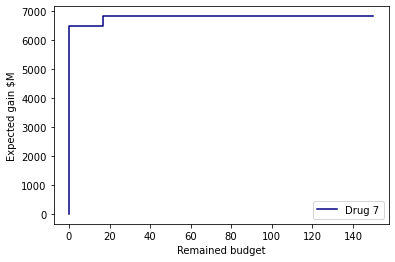

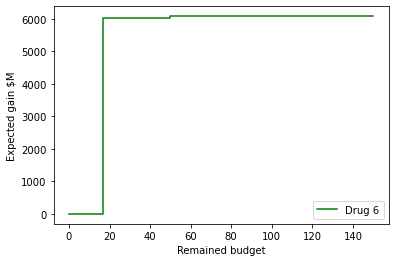

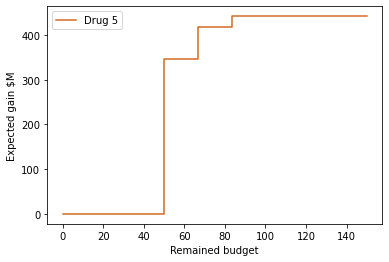

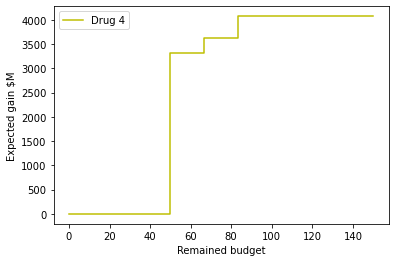

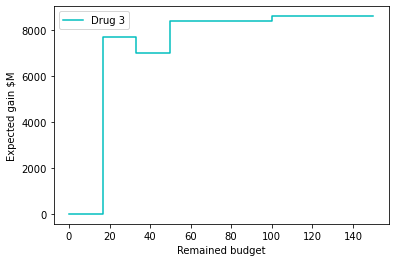

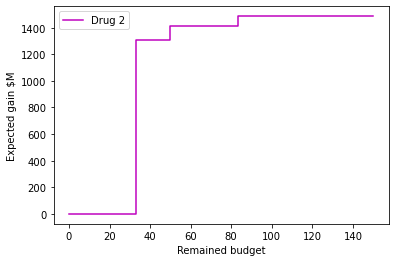

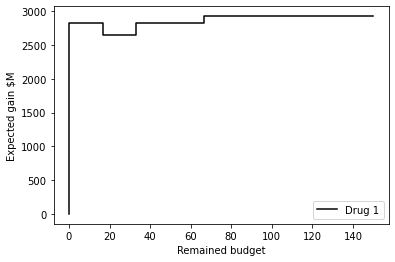

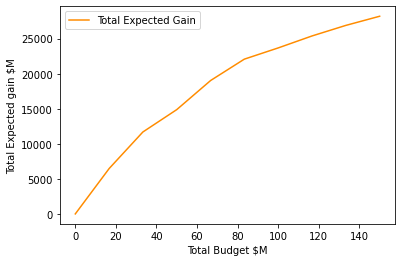

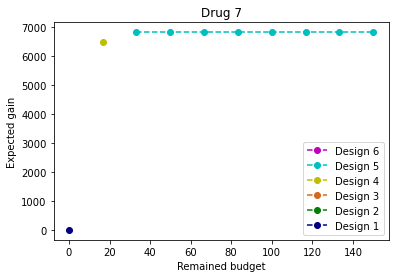

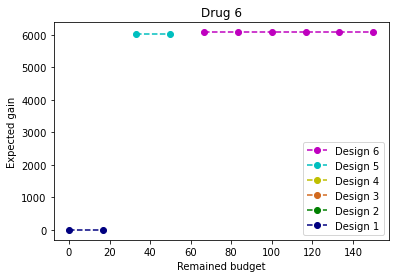

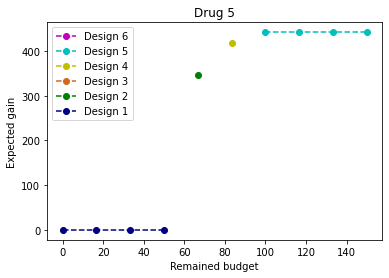

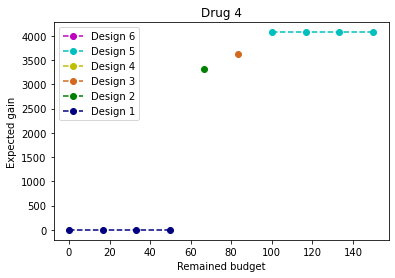

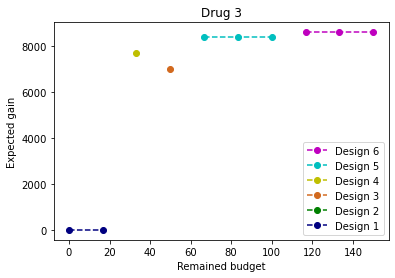

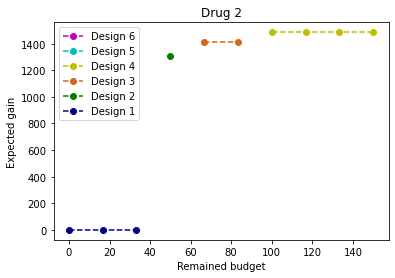

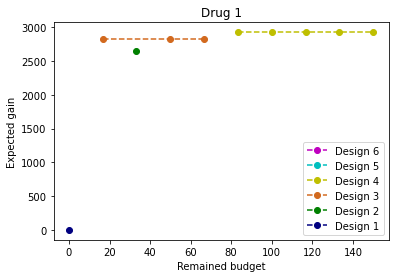

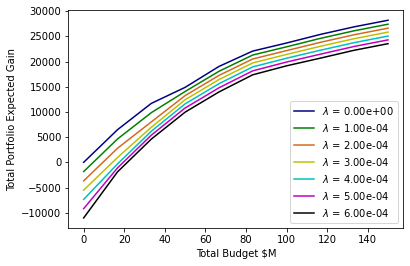

[    0.  2925.  4495. 10177.  8020. 21513. 23214. 22777. 27496. 27992.]
[    0.  2925. 10130. 14317. 15760. 22318. 23699. 23204. 23204. 23718.]
[    0.  8907. 13380. 20566. 20318. 22983. 23699. 23204. 23699. 23699.]


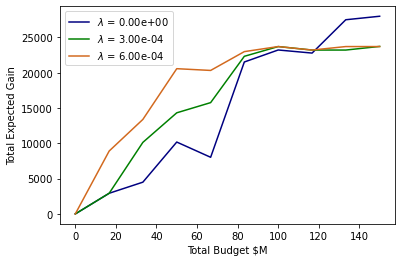

In [13]:
#Plot the optimal decision of each drug in each interval
# Continuous line plot of optimal expected gain for each drug in each interval
import os
a= np.loadtxt('rawData.txt', dtype = float, delimiter=None, converters=None, skiprows=0, usecols=None, unpack=False)
result = []
fig = []
for i in range(I):
    result.append(a[i*num_of_intervals:(i+1)*num_of_intervals,:])
    result[i] = np.array(result[i])
    fig.append(0)
color = ['navy','g','chocolate','y','c','m','k']
for i in range(I):
    temp = result[i]
    fig[i] = plt.figure("Figure "+str(i))
    plt.plot(temp[:,0],temp[:,1],drawstyle='steps',color=color[i],label='Drug '+str(I-i))
    plt.xlabel('Remained budget')
    plt.ylabel('Expected gain $M')
    plt.legend()
# Plot of Total expected gain for each drug in each interval using DP
fig.append(0)
fig[-1] = plt.figure("Figure final")
total = 0
for i in result:
        total+= i[:,1]
plt.plot(temp[:,0],eGainList[0],color= 'darkorange',label='Total Expected Gain')
plt.xlabel('Total Budget $M')
plt.ylabel('Total Expected gain $M')
plt.legend()
plt.show()

### Step plots to see the optimal decision of each drug in each interval togehter with the total expected gain
result = []
fig = []
for i in range(I):
    result.append(a[i*num_of_intervals:(i+1)*num_of_intervals,:])
    result[i] = np.array(result[i])
    fig.append(0)
color = ['navy','g','chocolate','y','c','m','k']
for i in range(I):
    temp = result[i]
    fig[i] = plt.figure("Figure "+str(i))
    for k in range(N_design,0,-1):
        index= 0
        index = (temp[:,2] == k)
        
        plt.plot(temp[index,0],temp[index,1],drawstyle='steps',color=color[k-1], linestyle='dashed',marker='o',label='Design '+str(k))
        plt.title('Drug '+str(I-i))
        plt.xlabel('Remained budget')
        plt.ylabel('Expected gain')
    plt.legend()
plt.show()


####################################################################################
# Effect of penalising the  \lambda * variance of the NPV in objective function on the objective value using DP 
colorindex = 0
for lambd in np.linspace(0,6*10e-5,7):
    os.remove("rawData.txt")
    eGainList = []
    master_func(opt_dec_list,I-1,lam = lambd)
    a= np.loadtxt('rawData.txt', dtype = float, delimiter=None, converters=None, skiprows=0, usecols=None, unpack=False)
    result = []
    temp = []
    
    for i in range(I):
        result.append(a[i*num_of_intervals:(i+1)*num_of_intervals,:])
        result[i] = np.array(result[i])
        temp = result[i]
    plt.plot(temp[:,0],eGainList[0],color= color[colorindex],label='$\lambda$ = '+str('{:.2e}'.format(lambd)))
    #plt.yscale('log')
    colorindex+=1

plt.xlabel('Total Budget $M')
plt.ylabel('Total Portfolio Expected Gain')
plt.legend()
plt.show()
####################################################################################
# Effect of penalising the  \lambda * variance of the NPV in objective function on the total expected value using DP 

colorindex = 0
for lambd in np.linspace(0,6*10e-5,3):
    os.remove("rawData.txt")
    eGainList = []
    master_func(opt_dec_list,I-1,lam = lambd)
    a= np.loadtxt('rawData.txt', dtype = float, delimiter=None, converters=None, skiprows=0, usecols=None, unpack=False)
    result = []
    temp = []
    e_gain =[]
    for i in range(I):
        result.append(a[i*num_of_intervals:(i+1)*num_of_intervals,:])
        result[i] = np.array(result[i])
        temp = result[i]
        index = temp[:,2]-np.ones(len(temp[:,2]))
        e_gain.append([])
        for k in range(len(index)):
           e_gain[-1].append(ExpectedGain[i,int(index[k])])
        e_gain[-1] = np.array(e_gain[-1])
    e_gain_total = np.sum(e_gain,axis=0)
    print(e_gain_total)
    plt.plot(temp[:,0],e_gain_total,color= color[colorindex],label='$\lambda$ = '+str('{:.2e}'.format(lambd)))
    #plt.yscale('log')
    colorindex+=1

plt.xlabel('Total Budget $M')
plt.ylabel('Total Expected Gain')
plt.legend()
plt.show()




Integer Programing 
, had been implemented in the MeanVar.py before

Objective function value 28192.0
Drug  1 

Design 3 - Cost: 15.8  Expected gain: 2823.0
Drug budget: 15.8
Drug gain: 2823.0

Drug  2 

Design 2 - Cost: 16.7  Expected gain: 1308.0
Drug budget: 16.7
Drug gain: 1308.0

Drug  3 

Design 5 - Cost: 36.1  Expected gain: 8366.0
Drug budget: 36.1
Drug gain: 8366.0

Drug  4 

Design 2 - Cost: 33.5  Expected gain: 3311.0
Drug budget: 33.5
Drug gain: 3311.0

Drug  5 

Drug budget: 0
Drug gain: 0

Drug  6 

Design 4 - Cost: 25.7  Expected gain: 5576.0
Drug budget: 25.7
Drug gain: 5576.0

Drug  7 

Design 5 - Cost: 20.4  Expected gain: 6808.0
Drug budget: 20.4
Drug gain: 6808.0

Total spent money: 148.2
Total gained money: 28192.0


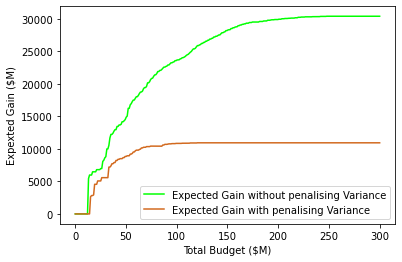

Time: 7.501742362976074


In [14]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import binpacking
from ortools.linear_solver import pywraplp
import sys
import time
np.set_printoptions(threshold = sys.maxsize)
np.random.seed(0)
#Objective function is max (ENPV-variance(NPV)) but as I did not have NPV here it is just max(ENPV)
#NPV is r_i and e_i is the expected gain
#Constraints are decision variables and budget

def init(B,I,N_design):

    #Data initialization

    Budget = np.loadtxt('Budget.txt', usecols=range(N_design))
    Data = np.loadtxt('Data.txt', usecols=range(I))
    ExpectedGain = np.loadtxt('Expected.txt',usecols=range(N_design))
    varNPV = np.zeros((7,6))
    Pos = np.zeros((I,N_design))
    one_beta = Data[18:24,:]
    P_i_a = Data[1,:]
    alpha_i = Data[3,:]
    n__trials = Data[16,:]
    r = np.zeros((I,N_design))

    #calculating PoSij
    for i in range(I):
        for j in range(N_design):
            Pos[i][j] = (one_beta[j][i]**n__trials[i])*P_i_a[i] + (alpha_i[i]**n__trials[i])*(1-P_i_a[i])
            if Pos[i][j] != 0: r[i][j] = (ExpectedGain[i][j]+Budget[i][j]*(1-Pos[i][j]))/Pos[i][j]
            else:r[i][j] = 0
    #calculating varNPV        
    for i in range(I):
        for j in range(N_design):
            varNPV[i][j] = np.sum((ExpectedGain-r[i][j])**2)/(I*N_design-1)

    #lambda = max(e_ij)/max(varNPV)
    #lmbda = np.max(ExpectedGain)/np.max(varNPV)
    return Budget, varNPV, ExpectedGain, P_i_a


def __main__(B,printFlag,lmbda = 0):
    I = 7
    B_Total = B
    N_design = 6
    Budget,varNPV,ExpectedGain, p_i_a = init(B,I,N_design)
    #lmbda = np.max(ExpectedGain)/np.max(varNPV)

    # Create the mip solver with the SCIP backend.
    # Also CBC can be used
    solver = pywraplp.Solver.CreateSolver('SCIP')
    x = {}
    for i in range(I):
        for j in range(N_design):
            x[(i, j)] = solver.IntVar(0, 1, 'x_%i_%i' % (i, j))
            

    # Constraints
    # Each drug can have at most one selected design.
    for i in range(I):
        solver.Add(sum(x[i, j] for j in range(N_design)) <= 1)
    # Budget constraint
    solver.Add(
        sum(x[(i, j)] * Budget[i][j] for i in range(I)
        for j in range(N_design)) <= B_Total)

    # Objective function
    objective = solver.Objective()
    for i in range(I):
        for j in range(N_design):
            objective.SetCoefficient(x[(i, j)], (ExpectedGain[i][j]-lmbda*varNPV[i][j]))
    objective.SetMaximization()
###################
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        if printFlag : print('Objective function value', objective.Value())
        total_cost = 0
        total_gain = 0
        for i in range(I):
            cost = 0
            eGain = 0
            if printFlag :print('Drug ', i+1, '\n')
            for j in range(N_design):
                if x[i, j].solution_value() > 0:
                    if printFlag :print('Design', j+1, '- Cost:', Budget[i][j], ' Expected gain:',
                        ExpectedGain[i][j])
                    cost += Budget[i][j]
                    eGain += ExpectedGain[i][j]
            if printFlag :print('Drug budget:', cost)
            if printFlag :print('Drug gain:', eGain)
            if printFlag :print()
            total_cost += cost
            total_gain += eGain
        if printFlag :print('Total spent money:', total_cost)
        if printFlag :print('Total gained money:', total_gain)

        return total_gain
    else:
        if printFlag :print('The problem does not have an optimal solution.')
        else: return 0


##Experiment

bInterval = np.linspace(0,300,num=300)
expectedReturn=[]
expectedWithVar=[]
lmbda = 10e-6

t = time.time()
for b in bInterval:
    ereturn = __main__(b,False)
    expectedReturn.append(ereturn)
    expectedWithVar.append(__main__(b,False,lmbda))
##The Optimal Decision for B = 150 M$ 
__main__(150,True)


##Plot
fig = plt.figure("Figure ")
plt.plot(bInterval,expectedReturn,'lime')
plt.plot(bInterval,expectedWithVar,'chocolate')
plt.xlabel('Total Budget ($M)')
plt.ylabel('Expexted Gain ($M)')
plt.legend(['Expected Gain without penalising Variance','Expected Gain with penalising Variance'])
plt.show()
t=time.time()-t
print('Time:',t)
